# **Transformer Interpretability Beyond Attention Visualization**

In [ ]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

!pip install einops

In [ ]:
from PIL import Image
from modules.layers_ours import Linear
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import cv2
import gdown

In [ ]:
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=19kk5sTPJm21vPk30qfQSr8UxgvdVph-O", # may need to change id after 'id='
    'model_best.pth.tar'
)
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=1eXlovBOixEswqHKE3md9lysb1YmQr4QA", # may need to change id after 'id='
    'samples/covid_221.png'
)
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=1bN-wmWaeYOnx3xqJTanzsMXgQ7StkHWY", # may need to change id after 'id='
    'samples/non_COVID (498).png'
)
gdown.download(
    f"https://drive.google.com/uc?export=download&confirm=pbef&id=18f2KCNKkSmFb4O6KGwJgJRwN5ryEKouR", # may need to change id after 'id='
    'samples/Normal (1926).png'
)

In [ ]:
#@title Lungs class indices to names
%%capture
CLS2IDX = {0: 'COVID-19', 1: 'Non-COVID', 2: 'Normal'}

In [ ]:
#@title Perform thresholding on the relevance (using Otsu's method)
#@title Number of layers for image Transformer
use_thresholding =  False#@param {type:"boolean"}

# **ViT examples**

In [ ]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
print(model.head)
# print(next(model.head.parameters()).device)
model.head = Linear(model.head.in_features, 3).cuda()
print(model.head)
# print(next(model.head.parameters()).device)
model.load_state_dict(torch.load('model_best.pth.tar')['state_dict'])
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_k_classes(k, predictions, **kwargs):    
    # Print Top-k predictionsfrom modules.layers_ours import
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(k, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print(f'Top {k} classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


Linear(in_features=768, out_features=1000, bias=True)
Linear(in_features=768, out_features=3, bias=True)


Top 3 classes:
	0 : COVID-19 		value = 6.148	 prob = 100.0%
	1 : Non-COVID		value = -3.084	 prob = 0.0%
	2 : Normal   		value = -4.326	 prob = 0.0%


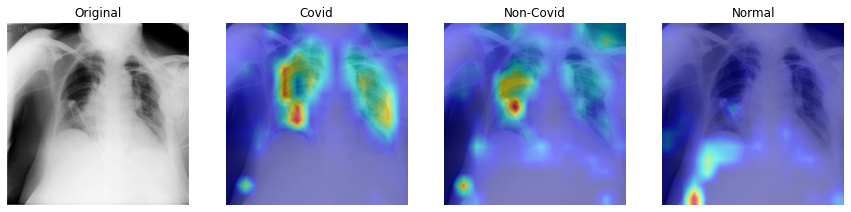

In [ ]:
#@title Covid
image = np.asarray(Image.open('samples/covid_221.png'))
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = Image.fromarray(image, mode="RGB")
covid_image = transform(image)

fig, axs = plt.subplots(1, 4, figsize=(15, 15))
axs[0].imshow(image);
axs[0].axis('off');
axs[0].title.set_text('Original')

output = model(covid_image.unsqueeze(0).cuda())
print_top_k_classes(3, output)

# covid
# covid = generate_visualization(covid_image) # or this, since covid is predicted class
covid = generate_visualization(covid_image, class_index=0)

# non covid
noncovid = generate_visualization(covid_image, class_index=1)

# normal
normal = generate_visualization(covid_image, class_index=2)


axs[1].imshow(covid);
axs[1].axis('off');
axs[1].title.set_text('Covid')
axs[2].imshow(noncovid);
axs[2].axis('off');
axs[2].title.set_text('Non-Covid')
axs[3].imshow(normal);
axs[3].axis('off');
axs[3].title.set_text('Normal')

Top 3 classes:
	1 : Non-COVID		value = 3.121	 prob = 98.5%
	0 : COVID-19 		value = -1.721	 prob = 0.8%
	2 : Normal   		value = -1.808	 prob = 0.7%


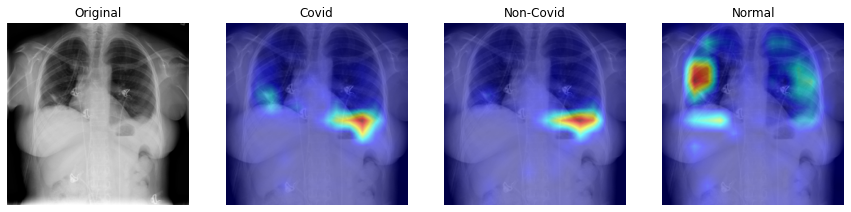

In [ ]:
#@title Non-Covid
image = np.asarray(Image.open('samples/non_COVID (498).png'))
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = Image.fromarray(image, mode="RGB")
covid_image = transform(image)

fig, axs = plt.subplots(1, 4, figsize=(15, 15))
axs[0].imshow(image);
axs[0].axis('off');
axs[0].title.set_text('Original')

output = model(covid_image.unsqueeze(0).cuda())
print_top_k_classes(3, output)

# covid
covid = generate_visualization(covid_image, class_index=0)

# non covid
noncovid = generate_visualization(covid_image, class_index=1)

# normal
normal = generate_visualization(covid_image, class_index=2)


axs[1].imshow(covid);
axs[1].axis('off');
axs[1].title.set_text('Covid')
axs[2].imshow(noncovid);
axs[2].axis('off');
axs[2].title.set_text('Non-Covid')
axs[3].imshow(normal);
axs[3].axis('off');
axs[3].title.set_text('Normal')

Top 3 classes:
	2 : Normal   		value = 2.167	 prob = 90.4%
	1 : Non-COVID		value = -0.251	 prob = 8.1%
	0 : COVID-19 		value = -1.905	 prob = 1.5%


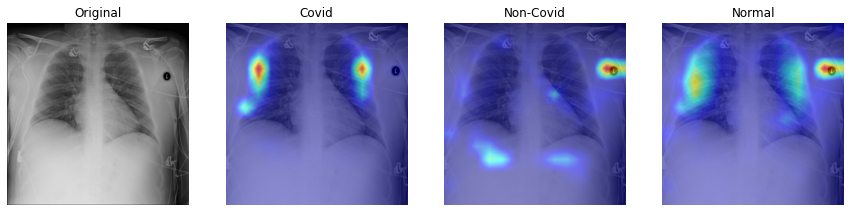

In [ ]:
#@title Normal
image = np.asarray(Image.open('samples/Normal (1926).png'))
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = Image.fromarray(image, mode="RGB")
covid_image = transform(image)

fig, axs = plt.subplots(1, 4, figsize=(15, 15))
axs[0].imshow(image);
axs[0].axis('off');
axs[0].title.set_text('Original')

output = model(covid_image.unsqueeze(0).cuda())
print_top_k_classes(3, output)

# covid
covid = generate_visualization(covid_image, class_index=0)

# non covid
noncovid = generate_visualization(covid_image, class_index=1)

# normal
normal = generate_visualization(covid_image, class_index=2)


axs[1].imshow(covid);
axs[1].axis('off');
axs[1].title.set_text('Covid')
axs[2].imshow(noncovid);
axs[2].axis('off');
axs[2].title.set_text('Non-Covid')
axs[3].imshow(normal);
axs[3].axis('off');
axs[3].title.set_text('Normal')